# Masoud (2020)

Given say:

$$
X = (X_1, X_2, \dots, X_d)
$$

and $P_i$ is a marginal distribution of $X_i$. Define:

$$
\sqrt{P} = (\sqrt{P_1}, \dots, \sqrt{P_d})
$$

Let $\Psi = \mathcal{E}_P[\sqrt{P}(\sqrt{P})^T]$ where $P$ is the joint distribution of $X$. Note that $\Psi > 0$.
Define:

$$
\kappa = \lambda_1 Tr(\Psi^{-1}) = \lambda_1 \sum_{i=1}^d\lambda^{-1}
$$
where $ 0 < \lambda 1 \leq \dots, \leq \lambda_l$, with $l \leq d$ are eigenvalues of $\Psi$.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import sys
import math
import scipy
from scipy.spatial.distance import pdist, squareform, cdist

sys.path.append("../..")
from src.main import *

In [6]:
from scipy import stats

def get_dist(X):
    kernel = stats.gaussian_kde(X)
    class rv(stats.rv_continuous):
        def _rvs(self, *x, **y):
            return kernel.resample(int(self._size))
        def _cdf(self, x):
            return kernel.integrate_box_1d(-np.Inf, x)
        def _pdf(self, x):
            return kernel(x)
    return rv(name="kdedist")

In [3]:
def plot_dist(func, value=[-10, 10], n = 200):
    fig = plt.figure()
    ax = fig.add_subplot()

    x_eval = np.linspace(value[0], value[1], num=n)
    ax.plot(x_eval, func.pdf(x_eval), 'r-', label="Silverman's Rule")

    plt.show()

In [20]:
gaussian = np.random.normal(0,1,5000)
gumbel = np.random.gumbel(0,1,5000)
laplace = np.random.laplace(0,1,5000)
logistic = np.random.logistic(10,1,5000)
uniform = np.random.uniform(0,1,5000)
gamma = np.random.gamma(2,2,5000)
pareto = np.random.pareto(3,5000)
weibull = np.random.weibull(5,5000)
beta = np.random.beta(2,2,5000)


(array([  3.,  12.,  29.,  71.,  88., 173., 343., 498., 639., 707., 722.,
        544., 478., 317., 202.,  97.,  44.,  21.,  10.,   2.]),
 array([-3.51501513, -3.16160614, -2.80819715, -2.45478816, -2.10137917,
        -1.74797018, -1.39456119, -1.0411522 , -0.68774321, -0.33433422,
         0.01907477,  0.37248376,  0.72589275,  1.07930174,  1.43271073,
         1.78611971,  2.1395287 ,  2.49293769,  2.84634668,  3.19975567,
         3.55316466]),
 <a list of 20 Patch objects>)

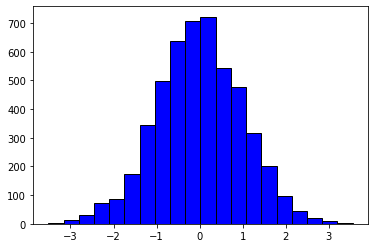

In [9]:
plt.hist(gaussian, color = 'blue', edgecolor = 'black',
         bins = 20)

In [21]:
kde_gaussian = get_dist(gaussian)
kde_gumbel = get_dist(gumbel)
kde_laplace = get_dist(laplace)
kde_logistic = get_dist(logistic)
kde_uniform = get_dist(uniform)
kde_gamma = get_dist(gamma)
kde_pareto = get_dist(pareto)
kde_weibull = get_dist(weibull)
kde_beta = get_dist(beta)

Gaussian

In [22]:
print(f"kde gaussian : {kde_gaussian.expect((lambda x : kde_gaussian.pdf(x)))}")
print(f"fast gaussian : {ip_est(gaussian, scaling=True)}")

kde gaussian : 0.27668542064558727
fast gaussian : 0.2758532788344166


Gumbel

In [23]:
print(f"kde Gumbel : {kde_gumbel.expect((lambda x : kde_gumbel.pdf(x)))}")
print(f"fast Gumbel : {ip_est(gumbel, scaling=True)}")

kde Gumbel : 0.24660754419396244
fast Gumbel : 0.24556214632488627


Laplace

In [24]:
print(f"kde laplace : {kde_laplace.expect((lambda x : kde_laplace.pdf(x)))}")
print(f"fast laplace : {ip_est(laplace, scaling=True)}")

kde laplace : 0.22985460820214437
fast laplace : 0.2285845456931456


In [31]:
laplace.var()

2.171534809960609

Logistic

In [25]:
print(f"kde logistic : {kde_logistic.expect((lambda x : kde_logistic.pdf(x)))}")
print(f"fast logistic : {ip_est(logistic, scaling=True)}")

kde logistic : 0.1673711616817458
fast logistic : 0.166785160532985


Uniform

In [26]:
print(f"kde uniform : {kde_uniform.expect((lambda x : kde_uniform.pdf(x)))}")
print(f"fast uniform : {ip_est(uniform, scaling=True)}")

kde uniform : 0.9442756394288513
fast uniform : 0.9396850651657613


Gamma

In [27]:
print(f"kde gamma : {kde_gamma.expect((lambda x : kde_gamma.pdf(x)))}")
print(f"fast gamma : {ip_est(gamma, scaling=True)}")

kde gamma : 0.12023679692498229
fast gamma : 0.11951964408469698


Pareto

In [28]:
print(f"kde pareto : {kde_pareto.expect((lambda x : kde_pareto.pdf(x)))}")
print(f"fast pareto : {ip_est(pareto, scaling=True)}")

kde pareto : 0.8657038832741932
fast pareto : 0.8467567366444682


Weibull

In [29]:
print(f"kde weibull : {kde_weibull.expect((lambda x : kde_weibull.pdf(x)))}")
print(f"fast weibull : {ip_est(weibull, scaling=True)}")

kde weibull : 1.2966728538641739
fast weibull : 1.292788415828052


Beta

In [30]:
print(f"kde beta : {kde_beta.expect((lambda x : kde_beta.pdf(x)))}")
print(f"fast beta : {ip_est(beta, scaling=True)}")

kde beta : 1.1699841413457528
fast beta : 1.1665495566964534


In [19]:
ip_est(gaussian, scaling=True)

0.2803549678356061

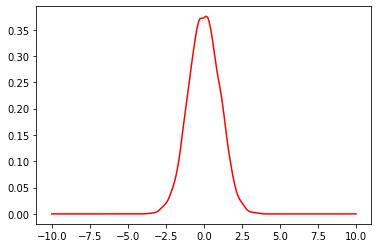

In [20]:
plot_dist(kde)

In [1]:
import numpy as np
import scipy.sparse as sps


def _lanczos_m(A, m, nv, rademacher, SV=None):
    '''
    Lanczos algorithm computes symmetric m x m tridiagonal matrix T and matrix V with orthogonal rows
        constituting the basis of the Krylov subspace K_m(A, x),
        where x is an arbitrary starting unit vector.
        This implementation parallelizes `nv` starting vectors.
    
    Arguments:
        m: number of Lanczos steps
        nv: number of random vectors
        rademacher: True to use Rademacher distribution, 
                    False - standard normal for random vectors
        SV: specified starting vectors
    
    Returns:
        T: a nv x m x m tensor, T[i, :, :] is the ith symmetric tridiagonal matrix
        V: a n x m x nv tensor, V[:, :, i] is the ith matrix with orthogonal rows 
    '''
    orthtol = 1e-5
    if type(SV) != np.ndarray:
        if rademacher:
            SV = np.sign(np.random.randn(A.shape[0], nv))
        else:
            SV = np.random.randn(A.shape[0], nv)  # init random vectors in columns: n x nv
    V = np.zeros((SV.shape[0], m, nv))
    T = np.zeros((nv, m, m))

    np.divide(SV, np.linalg.norm(SV, axis=0), out=SV)  # normalize each column
    V[:, 0, :] = SV

    w = A.dot(SV)
    alpha = np.einsum('ij,ij->j', w, SV)
    w -= alpha[None, :] * SV
    beta = np.einsum('ij,ij->j', w, w)
    np.sqrt(beta, beta)

    T[:, 0, 0] = alpha
    T[:, 0, 1] = beta
    T[:, 1, 0] = beta

    np.divide(w, beta[None, :], out=w)
    V[:, 1, :] = w
    t = np.zeros((m, nv))

    for i in range(1, m):
        SVold = V[:, i - 1, :]
        SV = V[:, i, :]

        w = A.dot(SV)  # sparse @ dense
        w -= beta[None, :] * SVold  # n x nv
        np.einsum('ij,ij->j', w, SV, out=alpha)

        T[:, i, i] = alpha

        if i < m - 1:
            w -= alpha[None, :] * SV  # n x nv
            # reortho
            np.einsum('ijk,ik->jk', V, w, out=t)
            w -= np.einsum('ijk,jk->ik', V, t)
            np.einsum('ij,ij->j', w, w, out=beta)
            np.sqrt(beta, beta)
            np.divide(w, beta[None, :], out=w)

            T[:, i, i + 1] = beta
            T[:, i + 1, i] = beta

            # more reotho
            innerprod = np.einsum('ijk,ik->jk', V, w)
            reortho = False
            for _ in range(100):
                if not (innerprod > orthtol).sum():
                    reortho = True
                    break
                np.einsum('ijk,ik->jk', V, w, out=t)
                w -= np.einsum('ijk,jk->ik', V, t)
                np.divide(w, np.linalg.norm(w, axis=0)[None, :], out=w)
                innerprod = np.einsum('ijk,ik->jk', V, w)

            V[:, i + 1, :] = w

            if (np.abs(beta) > 1e-6).sum() == 0 or not reortho:
                break
    return T, V


In [190]:
def _slq_ts_fs(A, m, niters, rademacher, fs):
    '''
    Compute the trace of matrix functions
    
    Arguments:
        A: square matrix in trace(exp(-t*A)), where t is temperature
        m: number of Lanczos steps
        niters: number of quadratures (also, the number of random vectors in the hutchinson trace estimator)
        ts: an array with temperatures
        rademacher: True to use Rademacher distribution, else - standard normal for random vectors in Hutchinson
        fs: a list of functions
    Returns:
        traces: estimate of traces for each of the functions in fs
    '''
    T, _ = _lanczos_m(A, m, niters, rademacher)
    eigvals, eigvecs = np.linalg.eigh(T)
    traces = np.zeros(len(fs))
    for i, f in enumerate(fs):
        expeig = f(eigvals).reshape(niters, m)
        sqeigv1 = np.power(eigvecs[:, 0, :], 2)
        traces[i] = A.shape[-1] * (expeig * sqeigv1).sum(-1).mean(-1)
    return traces

In [150]:
A = np.array([[1, 2], [2, 1]])

In [156]:
from numpy.linalg import inv, eig

In [161]:
ev, eq, = eig(inv(A))

In [162]:
sum(ev)

-0.6666666666666667

In [122]:
A.sum(-1).mean(-1)

2.0

In [191]:
_slq_ts_fs(A, A.shape[0], 10, True, [lambda x: x**(-1)])

array([-0.4])

In [57]:
from gpytorch.utils import StochasticLQ
from gpytorch.utils.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag

In [60]:
import torch

matrix = torch.randn(20, 20)

In [45]:
matrix

tensor([[ 0.9913, -2.8185,  0.3297, -0.7347,  0.2500, -2.5655],
        [-0.1037,  0.1106, -1.2937, -1.1849, -1.3688,  1.8920],
        [-0.5120,  0.8142, -1.0372, -1.5188, -1.7700,  0.9668],
        [-0.1670, -1.3917,  0.9944,  0.1848,  0.5638, -1.7850],
        [ 0.3129, -0.9364,  0.1178,  1.3176,  0.8074,  0.1947],
        [ 1.6353,  0.3539, -0.7056, -0.2318, -0.1581,  0.3138]])

In [38]:
q_mat, t_mat = lanczos_tridiag(
            matrix.matmul, max_iter=15, dtype=matrix.dtype, device=matrix.device, matrix_shape=matrix.shape
        )

In [61]:
slq = StochasticLQ()
q, t = lanczos_tridiag(matrix.matmul, max_iter=15, dtype=matrix.dtype, device=matrix.device, matrix_shape=matrix.shape)
eigval, eigvec = lanczos_tridiag_to_diag(t)

In [50]:
matrix.shape

torch.Size([6, 6])

In [62]:
slq.evaluate(matrix.shape, eigval, eigvec, [lambda x: x**(-1)])

IndexError: too many indices for tensor of dimension 1

In [52]:
eigval

tensor([[ 4.6499,  0.0000],
        [-3.0680,  0.0000],
        [ 1.1717,  0.0000],
        [-0.9215,  0.0000],
        [-0.4336,  0.0000],
        [-0.0279,  0.0000]])

In [53]:
eigvec

tensor([[-0.1305,  0.4495, -0.3439, -0.3584,  0.7183,  0.1353],
        [-0.4876, -0.7235, -0.4566,  0.0439,  0.1548,  0.0672],
        [-0.7715,  0.4806, -0.0563,  0.1706, -0.3709, -0.0626],
        [-0.3853, -0.2037,  0.7824, -0.3586,  0.2605, -0.0388],
        [-0.0394,  0.0454,  0.2377,  0.8193,  0.4335,  0.2843],
        [-0.0017, -0.0031,  0.0386, -0.2019, -0.2584,  0.9439]])

In [40]:
q_mat

tensor([[ 0.9656,  0.2600],
        [ 0.2600, -0.9656]])

In [41]:
t_mat

tensor([[-1.4085,  1.3226],
        [ 1.3226, -0.0672]])

In [39]:
q_mat.matmul(t_mat).matmul(q_mat.transpose(-1, -2))

tensor([[-0.6537, -1.4805],
        [-1.4805, -0.8219]])

In [ ]:

slq.evaluate(A, )

In [ ]:
def slq(A, f, m, n):
    n = A.shape[0]
    

In [5]:
def euclidean_dist_matrix(data_1, data_2):
    """
    Returns matrix of pairwise, squared Euclidean distances
    """
    norms_1 = (data_1 ** 2).sum(axis=1)
    norms_2 = (data_2 ** 2).sum(axis=1)
    return np.abs(norms_1.reshape(-1, 1) + norms_2 - 2 * np.dot(data_1, data_2.T))

In [17]:
def ip_est(data, scaling=False):

    if data.ndim > 1:
        d, n = data.shape
    else:
        d, n = 1, len(data)
        
    var = (n * (d + 2) / 4.)**(-1. / (d + 4)) * data.std()
    h = var*math.sqrt(2)
#     IQR = np.subtract.reduce(np.percentile(data, [75,25]))
#     A = min(std(data, ddof=1), IQR/1.349)
#     var = .9*A*n**(-1/5.)
#     h = var*math.sqrt(2)

    total = 0
    for i in range(n):
        for j in range(i):
            diff = data[j] - data[i]
            if scaling:
                total += 1/(math.sqrt(2.*np.pi)*h) * math.exp(-(diff**2)/(2*h**2))
            else:
                total += math.exp(-(diff**2)/(2*h**2))
    # 1/(math.sqrt(2.*np.pi)*h) 
#     curry = lambda f, x: lambda y: f(x, y)
#     gauss = lambda x, y: 1/(math.sqrt(2.*np.pi)*h) * math.exp(-((y - x)**2)/(2*h**2))
    total *= 2
    return 1/(n**2) * total


In [7]:
custom_run(2, 3, m=30, n=500, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

NameError: name 'custom_run' is not defined

In [13]:
M = {
     "10sphere": {
         "intdim": 10,
         "ambdim": 11,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_spheres(d = 10, r = 1, n=n))
     },
     "15sphere": {
         "intdim": 15,
         "ambdim": 16,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_spheres(d = 15, r = 1, n=n))
     },
     "affine_3_5": {
         "intdim": 3,
         "ambdim": 5,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_affine_3_5_space(n=n))
     },
     "concentrated": {
         "intdim": 4,
         "ambdim": 6,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_4_6_confusable_figure(n=n))
     },
     "nonlinear_4_8": {
         "intdim": 4,
         "ambdim": 8,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_affine_4_8_space(n=n))
     },
     "2d_helix" : {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_helix_2_3(n=n))
     },
     "nonlinear_6_36": {
         "intdim": 6,
         "ambdim": 36,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_affine_6_36_space(n=n))
     },
     "swiss_roll": {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_swiss_roll(n=n))
     },
     "nonlinear_12_72": {
         "intdim": 12,
         "ambdim": 72,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_12_manifold(n=n))
     },
     "affine_20_20": {
         "intdim": 20,
         "ambdim": 20,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_same_dim_space(20, n=n))
     },
     "uniform_10_hypercube": {
         "intdim": 10,
         "ambdim": 11,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(11, n=n))
     },
     "uniform_17_hypercube": {
         "intdim": 17,
         "ambdim": 18,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(18, n=n)),
     },
     "uniform_24_hypercube": {
         "intdim": 24,
         "ambdim": 25,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(25, n=n)),
     },
     "13_curve": {
         "intdim": 1,
         "ambdim": 13,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_kd_curve(13, n=n))
     },
     "10_mobius": {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_k_mobius(n=n, k=10))
     },
     "10_mobius_noisy": {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_k_mobius(n=n, k=10, noise=0.4))
     },
     "10_gaussian": {
         "intdim": 10,
         "ambdim": 10,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_multivariate_gaussian(10, n))
     }
}

In [191]:
dataset = generate_swiss_roll(n=500)

In [192]:
x1 = get_dist(dataset[0])
x2 = get_dist(dataset[1])
x3 = get_dist(dataset[2])

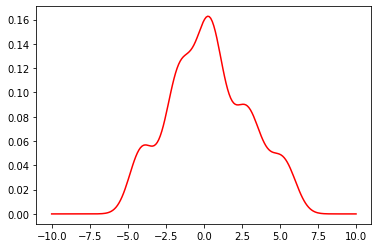

In [193]:
plot_dist(x1)

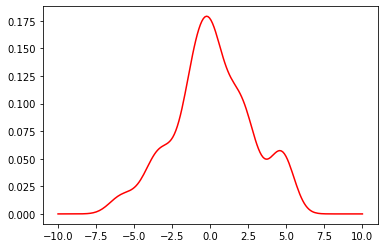

In [194]:
plot_dist(x2)

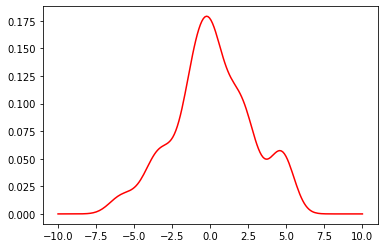

In [195]:
plot_dist(x3)

In [11]:
import math
def custom_run(intdim, ambdim, epsilon = 0.975, title = "", m = 20, n = 500, dataset = np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        eigenvalues = [0]*len(data)
        for j, d in enumerate(data):
            ip = ip_est(d, scaling=True)
            eigenvalues[j] = ip
#             marg = get_dist(d)
#             eigenvalues[j] = marg.expect(lambda x: marg.pdf(x), lb=-np.Inf, ub=np.Inf)
        values[i] = (min(i for i in eigenvalues if i > 0)*sum([lmbd**(-1) if (lmbd > 0) else 0 for lmbd in eigenvalues]))
    print(sum(values)/len(values))

In [10]:
import math
def custom_run(intdim, ambdim, epsilon = 0.975, title = "", m = 20, n = 500, dataset = np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        eigenvalues = [0]*len(data)
        for j, d in enumerate(data):
            ip = ip_est(d, scaling=True)
            eigenvalues[j] = ip
#             marg = get_dist(d)
#             eigenvalues[j] = marg.expect(lambda x: marg.pdf(x), lb=-np.Inf, ub=np.Inf)
        values[i] = math.log(min(i for i in eigenvalues if i > 0))*4*np.pi*(1/3)*math.log(np.prod([lmbd**(-1) if (lmbd > 0) else 0 for lmbd in eigenvalues]))
    print(sum(values)/len(values))

In [77]:
def custom_run_scaled(intdim, ambdim, epsilon = 0.975, title = "", m = 20, n = 500, dataset = np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        eigenvalues = [0]*len(data)
        for j, d in enumerate(data):
            ip = ip_est(d, scaling=True)
            eigenvalues[j] = ip
#             marg = get_dist(d)
#             eigenvalues[j] = marg.expect(lambda x: marg.pdf(x), lb=-np.Inf, ub=np.Inf)
        values[i] = min(i for i in eigenvalues if i > 0)*sum([lmbd**(-1) if (lmbd > 0) else 0 for lmbd in eigenvalues])
    print(sum(values)/len(values))

In [140]:
def custom_run_2(intdim, ambdim, epsilon = 0.975, title = "", m = 20, n = 500, dataset = np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        eigenvalues = [0]*len(data)
        for j, d in enumerate(data):
            ip = ip_est(d)
            eigenvalues[j] = ip
#             marg = get_dist(d)
#             eigenvalues[j] = marg.expect(lambda x: marg.pdf(x), lb=-np.Inf, ub=np.Inf)
        values[i] = (-math.log(min(i for i in eigenvalues if i > 0)))*sum([-math.log(lmbd) if (lmbd > 0) else 0 for lmbd in eigenvalues])
    print(sum(values)/len(values))

In [ ]:
def custom_run_2(intdim, ambdim, epsilon = 0.975, title = "", m = 20, n = 500, dataset = np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        eigenvalues = [0]*len(data)
        for j, d in enumerate(data):
            ip = ip_est(d)
            eigenvalues[j] = ip
#             marg = get_dist(d)
#             eigenvalues[j] = marg.expect(lambda x: marg.pdf(x), lb=-np.Inf, ub=np.Inf)
        values[i] = (max(i for i in eigenvalues if i > 0)**-1)*sum([lmbd if (lmbd > 0) else 0 for lmbd in eigenvalues])
    print(sum(values)/len(values))

In [216]:
## Testing computational feasibility

In [217]:
def run_cube(dataset = np.vectorize(lambda x, y: generate_k_hypercube(k = x, n = y))):
    for k in range(11, 26):
        custom_run(k-1, k, title=f"{k-1} hypercube", dataset=np.vectorize(lambda x: dataset(k, x)))

In [218]:
run_cube()

estimating ID for 10 hypercube
ID:  10


LinAlgError: singular matrix

In [10]:
def run_sphere(dataset = np.vectorize(lambda x, y: generate_spheres(d = x, n = y))):
    for k in range(60, 80):
        custom_run(k, k+1, title=f"{k} sphere", dataset=np.vectorize(lambda x: dataset(k, x)))

In [36]:
custom_run(2, 3, m=30, n=50, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

estimating ID for 
ID:  2
2.3737030495927787


In [37]:
custom_run(2, 3, m=30, n=500, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

estimating ID for 
ID:  2
2.3509127852295157


In [38]:
custom_run(2, 3, m=30, n=5000, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

estimating ID for 
ID:  2


KeyboardInterrupt: 

### Testing multiscaling

In [50]:
custom_run(2,3, dataset = M["10_mobius"]["dataset"])

estimating ID for 
ID:  2
1.9854800002745137


In [51]:
custom_run(2,3, dataset = M["10_mobius_noisy"]["dataset"])

estimating ID for 
ID:  2
1.9001053011682612


In [143]:
def run_sphere(dataset = np.vectorize(lambda x, y: generate_spheres(d = x, n = y))):
    for k in range(3, 6):
        custom_run(k, k+1, title=f"{k} sphere", dataset=np.vectorize(lambda x: dataset(k, x)))

In [144]:
run_sphere()

estimating ID for 3 sphere
ID:  3
2.9886172043436114
estimating ID for 4 sphere
ID:  4
3.4538955796718698
estimating ID for 5 sphere
ID:  5
3.74097300413234


In [54]:
custom_run(20, 20, title="20 - 20 same dimension", dataset=np.vectorize(lambda n: M["affine_20_20"]["dataset"](n)))

estimating ID for 20 - 20 same dimension
ID:  20
19.595728277324532


In [57]:
custom_run(**M["10_gaussian"])

estimating ID for 
ID:  10
9.537338383292148


In [61]:
custom_run(20,20,title="20 gaussian", dataset=np.vectorize(lambda n: generate_multivariate_gaussian(20, 1000)))

estimating ID for 20 gaussian
ID:  20
19.298239756717123


In [135]:
custom_run(2, 3, m=30, n=20, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

estimating ID for 
ID:  2
2.6253443467959365


In [63]:
custom_run(2, 3, m=30, n=500, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

estimating ID for 
ID:  2
2.754174861343444


In [64]:
custom_run(2, 3, m=30, n=5000, dataset = np.vectorize(lambda n: generate_helix_2_3(n)))

estimating ID for 
ID:  2


KeyboardInterrupt: 

In [83]:
custom_run(3, 5, m=30, n=500, dataset = np.vectorize(lambda n : generate_affine_3_5_space(n=n)))

estimating ID for 
ID:  3
2.818169824612013


In [97]:
custom_run(3, 5, m=30, n=200, dataset = np.vectorize(lambda n : generate_affine_3_5_space(n=n)))

estimating ID for 
ID:  3
3.1210781863557573


In [87]:
custom_run(3, 5, m=30, n=50, dataset = np.vectorize(lambda n : generate_affine_3_5_space(n=n)))

estimating ID for 
ID:  3
2.8996067774577017


In [94]:
custom_run(3, 5, m=30, n=100, dataset = np.vectorize(lambda n : generate_affine_3_5_space(n=n)))

estimating ID for 
ID:  3
3.001201995812411


In [ ]:
custom_run(3, 5, m=30, n=50, dataset = np.vectorize(lambda n : generate_affine_3_5_space(n=n)))

In [98]:
custom_run(4, 8, m=30, n=500, dataset = np.vectorize(lambda n : generate_affine_4_8_space(n=n)))

estimating ID for 
ID:  4
6.994199858757922


In [99]:
custom_run(4, 8, m=30, n=200, dataset = np.vectorize(lambda n : generate_affine_4_8_space(n=n)))

estimating ID for 
ID:  4
6.444252767487914


In [100]:
custom_run(4, 8, m=30, n=100, dataset = np.vectorize(lambda n : generate_affine_4_8_space(n=n)))

estimating ID for 
ID:  4
5.9025647387870785


In [113]:
custom_run(4, 8, m=30, n=20, dataset = np.vectorize(lambda n : generate_affine_4_8_space(n=n)))

estimating ID for 
ID:  4
4.575501557652625


In [122]:
custom_run(6, 36, m=30, n=10, dataset = np.vectorize(lambda n : generate_affine_6_36_space(n=n)))

estimating ID for 
ID:  6
15.039162048863801


In [125]:
custom_run(12, 72, m=30, n=100, dataset = np.vectorize(lambda n : generate_12_manifold(n=n)))

estimating ID for 
ID:  6
46.55617540022859


In [127]:
custom_run(12, 72, m=30, n=20, dataset = np.vectorize(lambda n : generate_12_manifold(n=n)))

estimating ID for 
ID:  12
27.220706770171283


In [14]:
for key, value in M.items():
    custom_run(**value, title=key, epsilon = 0.975)

estimating ID for 10sphere
ID:  10
4.625010176807393
estimating ID for 15sphere
ID:  15
5.187768199386634
estimating ID for affine_3_5
ID:  3
4.234792197638729
estimating ID for concentrated
ID:  4
4.030281593994079
estimating ID for nonlinear_4_8
ID:  4
6.192154344498179
estimating ID for 2d_helix
ID:  2
2.2856099302603536
estimating ID for nonlinear_6_36
ID:  6
27.541723203161336
estimating ID for swiss_roll
ID:  2
2.674332677677901
estimating ID for nonlinear_12_72
ID:  12
50.977259015921575
estimating ID for affine_20_20
ID:  20
16.18871238220309
estimating ID for uniform_10_hypercube
ID:  10
8.37619056529017
estimating ID for uniform_17_hypercube
ID:  17


<ipython-input-6-feb0eb63dc8e>:20: RuntimeWarning: divide by zero encountered in double_scalars
  total += 1/(math.sqrt(2.*np.pi)*h) * math.exp(-(diff**2)/(2*h**2))
<ipython-input-6-feb0eb63dc8e>:20: RuntimeWarning: invalid value encountered in double_scalars
  total += 1/(math.sqrt(2.*np.pi)*h) * math.exp(-(diff**2)/(2*h**2))


14.129361324072661
estimating ID for uniform_24_hypercube
ID:  24
18.785589872616065
estimating ID for 13_curve
ID:  1
8.099548444052065
estimating ID for 10_mobius
ID:  2
2.1620672293440175
estimating ID for 10_mobius_noisy
ID:  2
2.267619222047443
estimating ID for 10_gaussian
ID:  10
7.685067011980766


In [79]:
for key, value in M.items():
    custom_run_scaled(**value, title=key, epsilon = 0.975)

estimating ID for 10sphere
ID:  10
4.362285354480169
estimating ID for 15sphere
ID:  15
5.192926467161781
estimating ID for affine_3_5
ID:  3
4.266098761688041
estimating ID for concentrated
ID:  4
3.96991268605158
estimating ID for nonlinear_4_8
ID:  4
6.116742071574562
estimating ID for 2d_helix
ID:  2
2.286662186907
estimating ID for nonlinear_6_36
ID:  6
27.245723200535128
estimating ID for swiss_roll
ID:  2
2.7455451378432256
estimating ID for nonlinear_12_72
ID:  12
52.377715664662254
estimating ID for affine_20_20
ID:  20
15.989047759138767
estimating ID for uniform_10_hypercube
ID:  10


<ipython-input-75-feb0eb63dc8e>:20: RuntimeWarning: divide by zero encountered in double_scalars
  total += 1/(math.sqrt(2.*np.pi)*h) * math.exp(-(diff**2)/(2*h**2))
<ipython-input-75-feb0eb63dc8e>:20: RuntimeWarning: invalid value encountered in double_scalars
  total += 1/(math.sqrt(2.*np.pi)*h) * math.exp(-(diff**2)/(2*h**2))


8.30623729862676
estimating ID for uniform_17_hypercube
ID:  17
13.804026539773545
estimating ID for uniform_24_hypercube
ID:  24
19.34839072343454
estimating ID for 13_curve
ID:  1
8.122305681013366
estimating ID for 10_mobius
ID:  2
2.0751478016257368
estimating ID for 10_mobius_noisy
ID:  2
2.389308895077293
estimating ID for 10_gaussian
ID:  10
7.497180377287071


In [142]:
for key, value in M.items():
    custom_run_2(**value, title=key, epsilon = 0.975)

estimating ID for 10sphere
ID:  10
-2.242389645215218
estimating ID for 15sphere
ID:  15
-11.882990048810797
estimating ID for affine_3_5
ID:  3
0.4235699854151559
estimating ID for concentrated
ID:  4
2.9520340250115122
estimating ID for nonlinear_4_8
ID:  4
1.4804202583920354
estimating ID for 2d_helix
ID:  2
9.800199719526713
estimating ID for nonlinear_6_36
ID:  6
6.8422123291124475
estimating ID for swiss_roll
ID:  2
15.224312592469829
estimating ID for nonlinear_12_72
ID:  12
13.873767874147674
estimating ID for affine_20_20
ID:  20
59.9808809886876
estimating ID for uniform_10_hypercube
ID:  10
0.13884788630261244
estimating ID for uniform_17_hypercube
ID:  17
0.24392629651773273
estimating ID for uniform_24_hypercube
ID:  24
0.3530171508698281
estimating ID for 13_curve
ID:  1
-0.773228234731848
estimating ID for 10_mobius
ID:  2
1.738190556916204
estimating ID for 10_mobius_noisy
ID:  2
3.3174036815199366
estimating ID for 10_gaussian
ID:  10
17.984241454076855


In [205]:
X = np.random.normal(0, 2, size=(400,))

In [206]:
emp_norm = get_dist(X)

In [167]:
from math import log

In [207]:
emp_norm.entropy()

array(2.18217156)

In [208]:
emp_norm.expect(lambda x: -log(emp_norm.pdf(x)), lb=-15, ub=15)

2.1821715621232873

In [210]:
(emp_norm.expect(lambda x: emp_norm.pdf(x), lb=-np.Inf, ub=np.Inf))**(-1)

7.494321099978269

In [151]:
emp_norm.expect(lambda x: x, lb=-5.0, ub=5.0)

0.9072375800924124

In [146]:
emp_norm.pdf(np.arange(-5,5, 0.5))

array([7.38722834e-39, 8.97432633e-32, 1.98002948e-25, 7.94646200e-20,
       5.81408740e-15, 7.78116254e-11, 1.91494816e-07, 8.74517851e-05,
       7.54203515e-03, 1.27705821e-01, 4.69687484e-01, 5.01431010e-01,
       3.04608127e-01, 1.91294604e-01, 1.10795667e-01, 7.20745543e-02,
       6.67857845e-02, 4.79593386e-02, 2.93347384e-02, 2.34777598e-02])

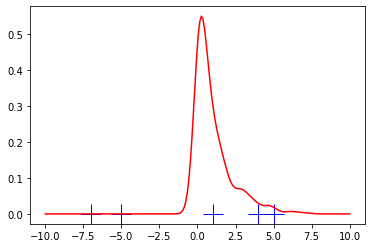

In [148]:
plot_dist()